In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

In [4]:
flowers = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/iris.csv')
flowers

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


# Introduction
In this project I used the Iris dataset. I was looking for a relationship in the dataset that would be linear. I found that the petal_length vs sepal length is a linear relationship. Petal length is just the length of the petals on the different flowers. The sepal length is the length of that green covering that surrounds the bottom of the petals. The petals are always going to be longer than the sepals on every flower, but as the petal length gets larger so does the sepal length. I graphed it on a scatter plot to see the linear relationship.

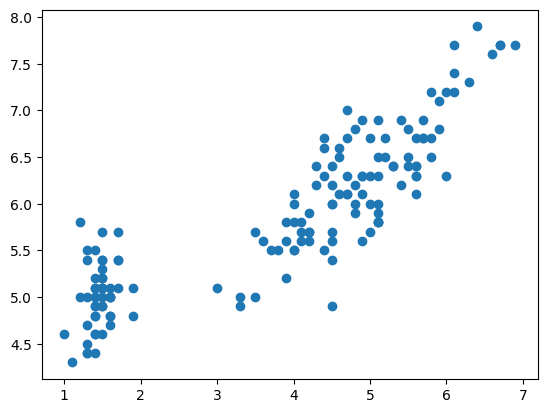

In [ ]:
plt.scatter(x=flowers.petal_length, y=flowers.sepal_length)

# First Model
In my first model I just wanted to find a slope and y-intercept as my priors that match the scatter plot graph pretty well. My model was a linear regression model.

In [ ]:
with pm.Model() as flowers_model:
  α = pm.Normal("α", sigma=10)
  β = pm.Normal("β", sigma=10)

  μ = pm.Deterministic("μ", α + β * flowers.petal_length)

  σ = pm.HalfNormal("σ", sigma = 10)

  y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=flowers.sepal_length)

  idata_lba = pm.sample()

Output()

Output()

Text(0, 0.5, 'sepal_length')

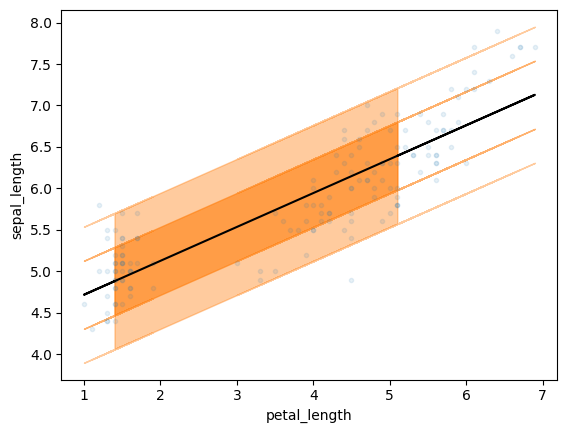

In [ ]:
_, ax = plt.subplots()

ax.plot(flowers.petal_length, flowers.sepal_length, "C0.", alpha=0.1)

posterior_lba = az.extract(idata_lba)

μ_m = posterior_lba["μ"].mean("sample").values
σ_m = posterior_lba["σ"].mean("sample").values

ax.plot(flowers.petal_length, μ_m, c="k")
ax.fill_between(flowers.petal_length, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(flowers.petal_length, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("petal_length")
ax.set_ylabel("sepal_length")

In [ ]:
pm.sample_posterior_predictive(
    idata_lba, model = flowers_model, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

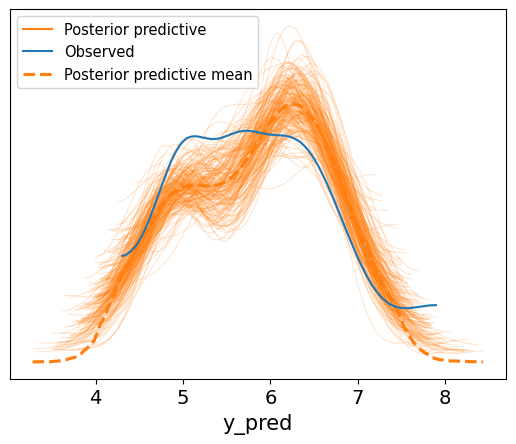

In [ ]:
az.plot_ppc(idata_lba, num_pp_samples=200, colors=["C1", "C0", "C1"])

# First Model Results
The results of my first model were ok. They weren't great as they didn't match the middle part of the observed data very well.

<Axes: ylabel='sepal_length'>

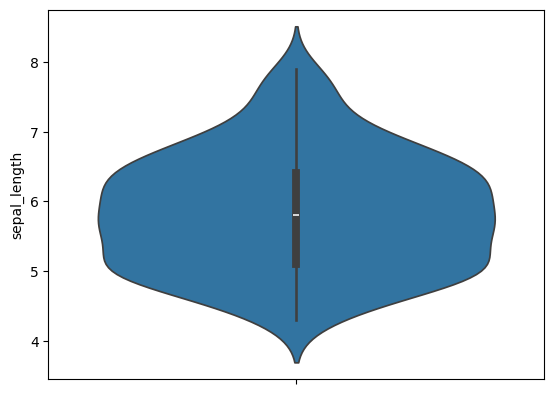

In [7]:
sns.violinplot(flowers.sepal_length)

# Second Model
As shown in the observed data and in the violin plot the slope of the graph increases as my x variable increases. To represent this I made a model using a + bx^2. which allowed my model to represent the trend in the data.

In [ ]:
with pm.Model() as flowers_model2:
    # Intercept and slope priors
    α = pm.Normal("α", mu=5, sigma=1)  # Centered on typical sepal lengths
    β = pm.Normal("β", mu=5, sigma=10)  # Weakly informative slope
    σ = pm.HalfNormal("σ", sigma=2)    # Plausible variation scale

    # Linear model
    μ = pm.Deterministic("μ", α + β * (flowers["petal_length"]*flowers['petal_length']))

    # Likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=flowers["sepal_length"])

    # Sampling
    idata_flowers2 = pm.sample()

Output()

Output()

Text(0, 0.5, 'sepal_length')

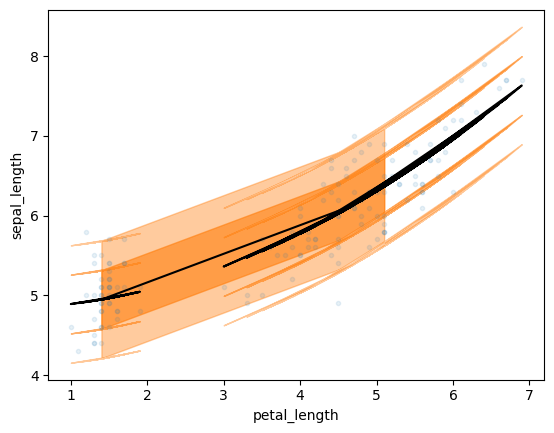

In [ ]:
_, ax = plt.subplots()

ax.plot(flowers.petal_length, flowers.sepal_length, "C0.", alpha=0.1)

posterior_lba = az.extract(idata_flowers2)

μ_m = posterior_lba["μ"].mean("sample").values
σ_m = posterior_lba["σ"].mean("sample").values

ax.plot(flowers.petal_length, μ_m, c="k")
ax.fill_between(flowers.petal_length, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(flowers.petal_length, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("petal_length")
ax.set_ylabel("sepal_length")

# Second Model Graph
As shown in the graph above my new model matches the data a lot better and hopefully my posterior predictive check will be more accurate than my first model.

In [ ]:
pm.sample_posterior_predictive(
    idata_flowers2, model = flowers_model2, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

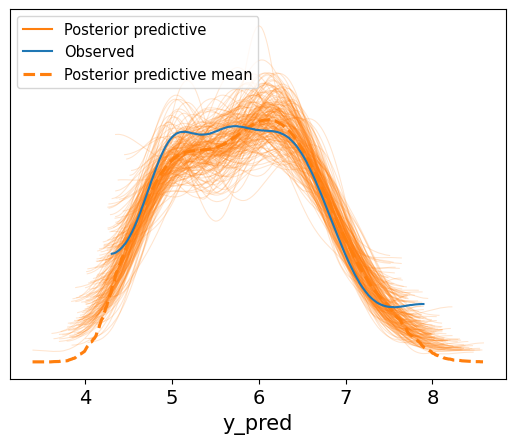

In [ ]:
az.plot_ppc(idata_flowers2, num_pp_samples=200, colors=["C1", "C0", "C1"])

# Second Model Results
My second model matches the observed data a lot better. The middle of the dataset is now accurately represented by my model and I maintained an accurate graph on each side of the middle part. It isn't perfect, but I think it is really good.

# Conclusion
I made a model that can predict the sepal length of a flower based on it's petal length. This can be really useful in many different areas. I think that it would be useful in studying plants that are dead or have been fossilized. If you have a plants petal that fell off the plant and you don't have the actual plants, with this model you can still accurately figure out the length of its sepal. If you have a fossil of the plant and you can only accurately measure the petal length, you can still accurately predict the sepal length.